## Visualize Cell Health Predictions on Repurposing Hub Data

**Gregory Way, 2019**

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

## Load and Process Data

In [2]:
# Load Data
data_dir <- file.path("data", "repurposing_transformed")
real_file <- file.path(data_dir, "repurposing_umap_transformed_cell_painting.tsv.gz")

cp_embedding_df <- readr::read_tsv(real_file, col_types = readr::cols())

cell_health_file <- file.path(data_dir, "repurposing_transformed_real_models.tsv.gz")
cell_health_df <- readr::read_tsv(cell_health_file, col_types = readr::cols()) 

# Merge data together
cp_embedding_df <- cp_embedding_df %>%
    dplyr::left_join(cell_health_df,
                     by = c("Metadata_broad_sample", "Metadata_dose_recode", "Image_Metadata_Well")) %>%
    dplyr::mutate(Metadata_Treatment = cp_embedding_df$Image_Metadata_Well)

cp_embedding_df$Metadata_Treatment[cp_embedding_df$Image_Metadata_Well == "collapsed"] = "Compound"
cp_embedding_df$Metadata_Treatment[cp_embedding_df$Image_Metadata_Well != "collapsed"] = "DMSO"

print(dim(cp_embedding_df))
head(cp_embedding_df, 3)

[1] 9418   76


Metadata_broad_sample  Metadata_dose_recode Image_Metadata_Well umap_x   
1 BRD-A00147595-001-01-5 1                    collapsed           -2.970464
2 BRD-A00147595-001-01-5 2                    collapsed           -3.245655
3 BRD-A00147595-001-01-5 3                    collapsed           -2.744096
  umap_y    cc_cc_g1_mean cc_mitosis_ph3_neg_n_spots_mean
1 1.1957064  0.12063406   0.1783815                      
2 0.5795504 -0.03980260   0.1943891                      
3 0.6926972  0.01884117   0.2073830                      
  cc_edu_pos_high_n_spots_h2ax_mean cc_polyploid_n_spots_mean
1 0.1997622                         0.2988695                
2 0.2254152                         0.3027778                
3 0.2665627                         0.2512733                
  vb_live_cell_roundness ⋯ cc_cc_n_spots_mean vb_ros_back_mean cc_g1_n_objects
1  0.096741107           ⋯ 0.1974630          -0.23612664      0.4139967      
2 -0.004162555           ⋯ 0.1968687          -0.07821680      0.1828436      
3 -0.019050161           ⋯ 0.1161710          -0.01614199      0.2253924      
  vb_percent_all_apoptosis cc_all_high_n_spots_h2ax_mean
1 -0.27155267              0.2310497                    
2 -0.06529125              0.2262011                    
3 -0.01727995              0.1856053                    
  cc_all_large_round_polyploid_mean cc_edu_pos_n_objects cc_all_n_objects
1 0.2186928                         0.3852050            0.3778692       
2 0.5698721                         0.1877323            0.1932057       
3 0.5158029                         0.2264340            0.2188536       
  cc_g1_n_spots_per_nucleus_area_mean Metadata_Treatment
1 -0.2145808                          Compound          
2 -0.1351521                          Compound          
3 -0.1447703                          Compound

In [3]:
table(cp_embedding_df$Metadata_dose_recode, cp_embedding_df$Metadata_Treatment)

   
    Compound DMSO
  0        0   24
  1     1568    0
  2     1568    0
  3     1568    0
  4     1568    0
  5     1562    0
  6     1558    0
  7        2    0

## Visualize Metadata and Cell Health Variables

Warning message:
“Using size for a discrete variable is not advised.”

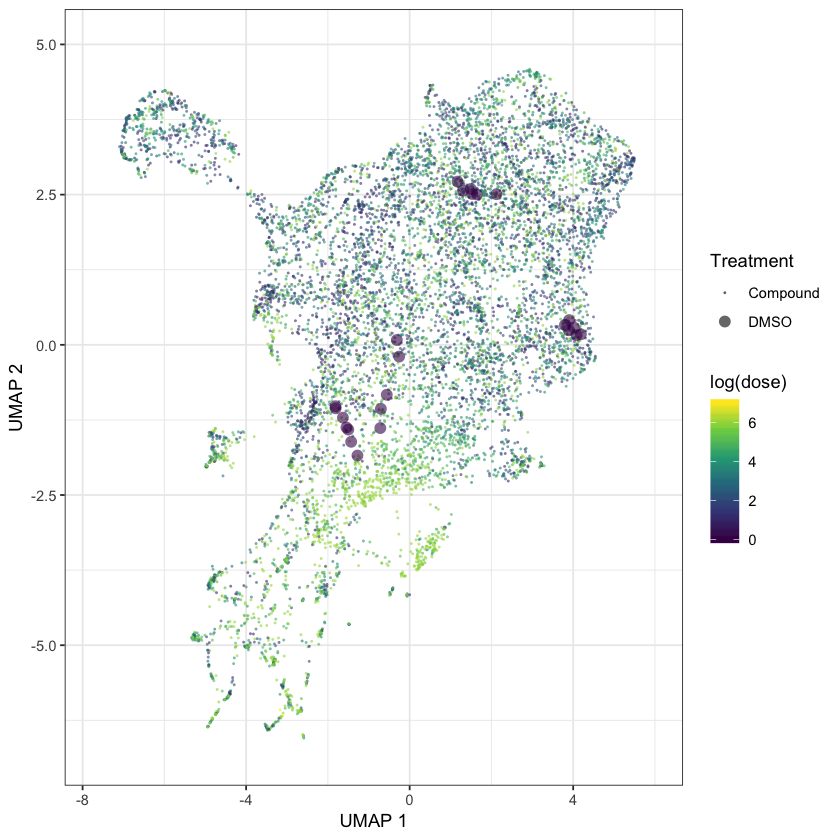

In [4]:
ggplot(cp_embedding_df,
       aes(x = umap_x, y = umap_y)) +
    geom_point(aes(color = Metadata_dose_recode,
                   size = paste(Metadata_Treatment)),
               pch = 16,
               alpha = 0.6) +
    theme_bw() +
    scale_color_viridis_c(name = "log(dose)") +
    xlim(c(-7.75, 6)) +
    ylim(c(-6.75, 5)) +
    scale_size_discrete("Treatment",
                        range = c(0.5, 3)) +
    xlab("UMAP 1") +
    ylab("UMAP 2")

output_file <- file.path("figures", "umap_repurposing_cell_painting_dose_consensus.png")
ggsave(output_file, height = 5, width = 6, dpi = 500)

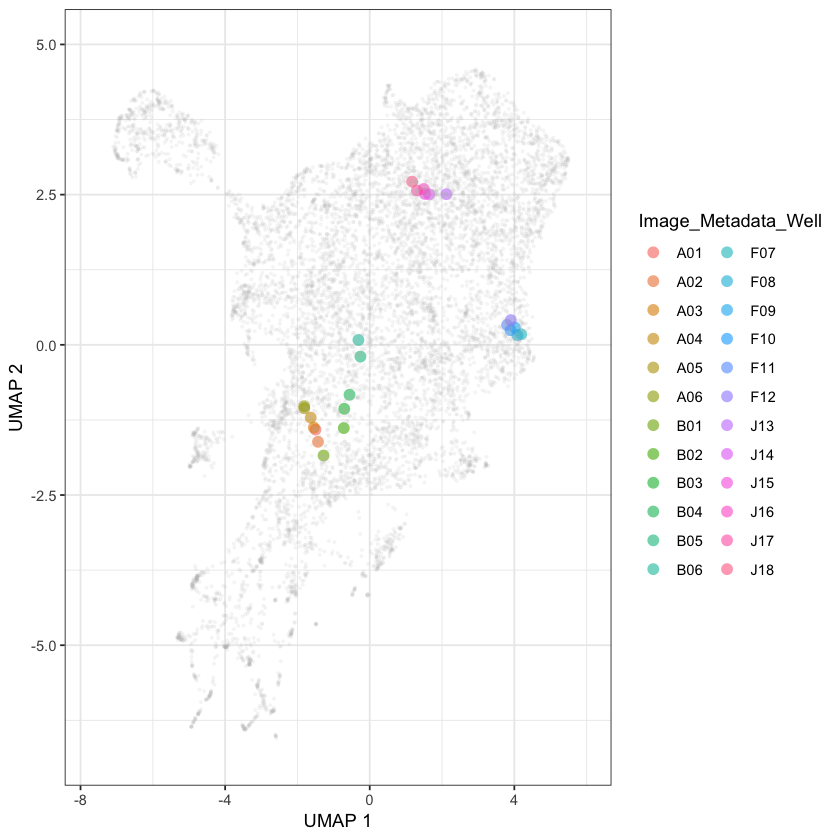

In [5]:
ggplot(cp_embedding_df %>% dplyr::filter(Metadata_Treatment == "DMSO"),
       aes(x = umap_x, y = umap_y)) +
    geom_point(aes(color = Image_Metadata_Well),
               pch = 16,
               size = 3,
               alpha = 0.6) +
    geom_point(data = cp_embedding_df, color = "grey", alpha = 0.1, size = 0.5) +
    xlim(c(-7.75, 6)) +
    ylim(c(-6.75, 5)) +
    theme_bw() +
    xlab("UMAP 1") +
    ylab("UMAP 2")

output_file <- file.path("figures", "umap_repurposing_cell_painting_dose_consensus_dmso.png")
ggsave(output_file, height = 5, width = 6, dpi = 500)

## Certain Models had Better Performance in A549

We applied all models to the Drug Repurposing Set data.

Here, output visualizations of several of the top models.

![Performance Rank](../3.train/figures/ranked_models_A549.png)

In [6]:
visualize_model <- function(target_variable, legend_title, title = "none", dpi = 500, save_figure = TRUE) {
    plot_gg <- ggplot(cp_embedding_df, aes(x = umap_x, y = umap_y)) +
        geom_point(aes_string(color = target_variable),
                   size = 0.5,
                   pch = 16,
                   alpha = 0.6) +
        theme_bw() +
        scale_color_viridis_c(name = legend_title) +
        xlab("UMAP 1") +
        ylab("UMAP 2")
    
    if (title != "none") {
        plot_gg <- plot_gg + ggtitle(title)
    }
    if (save_figure) {
        output_file <- file.path("figures",
                                 paste0("umap_repurposing_cell_painting_",
                                        target_variable,
                                        "_consensus.png"))
        ggsave(output_file, height = 5, width = 6, dpi = dpi)
    }
    
    print(plot_gg)
}

In [7]:
# Load feature mapping
mapping_dir <- file.path("..", "1.generate-profiles", "data", "labels")
mapping_file <- file.path(mapping_dir, "feature_mapping_annotated.csv")
map_df <- readr::read_csv(mapping_file,
                          col_types = readr::cols(.default = readr::col_character()))

print(dim(map_df))
head(map_df, 3)

[1] 75  7


original_name updated_name feature_type measurement maria_thumbs_up assay
1 Row           well_row     metadata     NA          NA              NA   
2 Column        well_col     metadata     NA          NA              NA   
3 Plate Name    plate_name   metadata     NA          NA              NA   
  description
1 NA         
2 NA         
3 NA

## Visualizing Compound Dosage

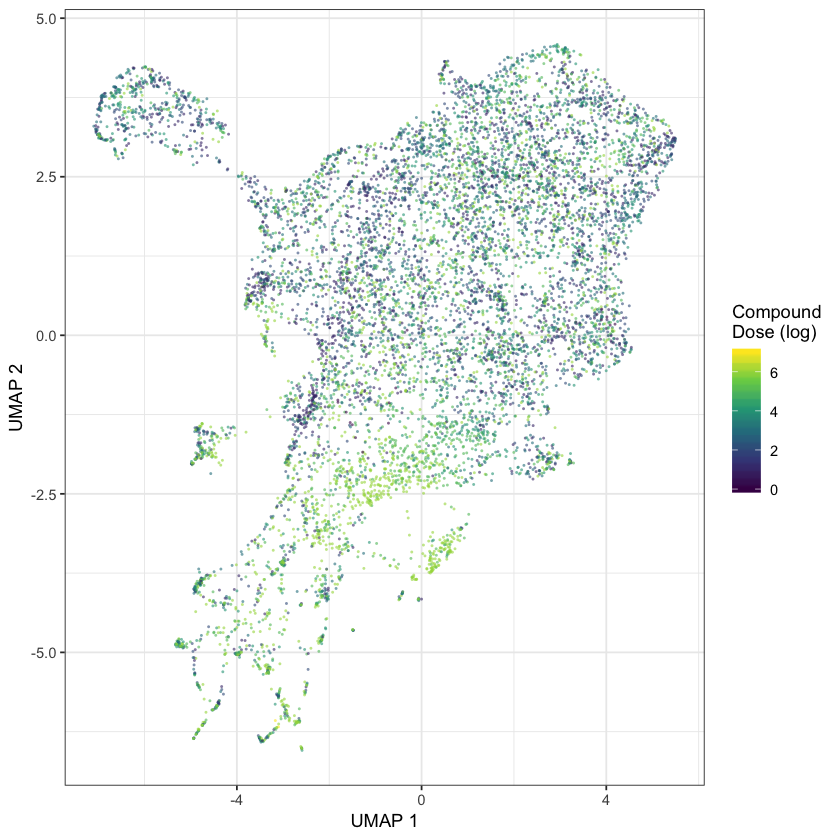

In [8]:
visualize_model(target_variable = "Metadata_dose_recode",
                legend_title = "Compound\nDose (log)") 

## Predicting Number of Live Cells (DRAQ7)

In [9]:
map_df %>% filter(original_name == "# Live Cells")

original_name updated_name      feature_type measurement maria_thumbs_up
1 # Live Cells  vb_num_live_cells viability    death       1              
  assay description         
1 draq  number of live cells

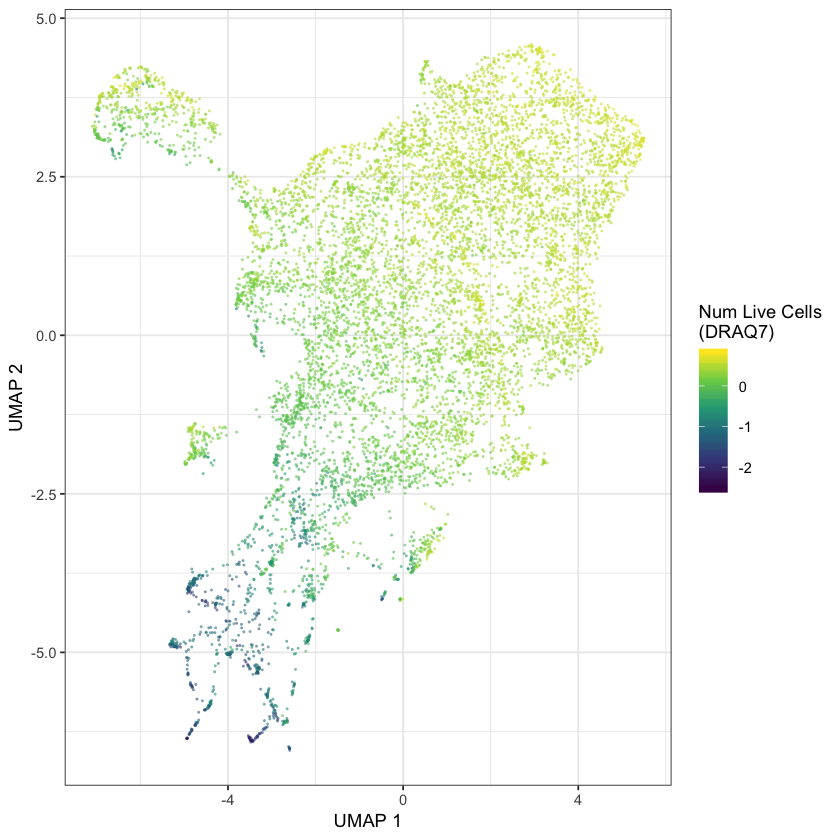

In [10]:
visualize_model(target_variable = "vb_num_live_cells",
                legend_title = "Num Live Cells\n(DRAQ7)")

## Predicting Live Width:Length (DRAQ7)

In [11]:
map_df %>% filter(original_name == "Live Width:Length")

original_name     updated_name              feature_type measurement
1 Live Width:Length vb_live_cell_width_length viability    NA         
  maria_thumbs_up assay description 
1 0               draq  width/length

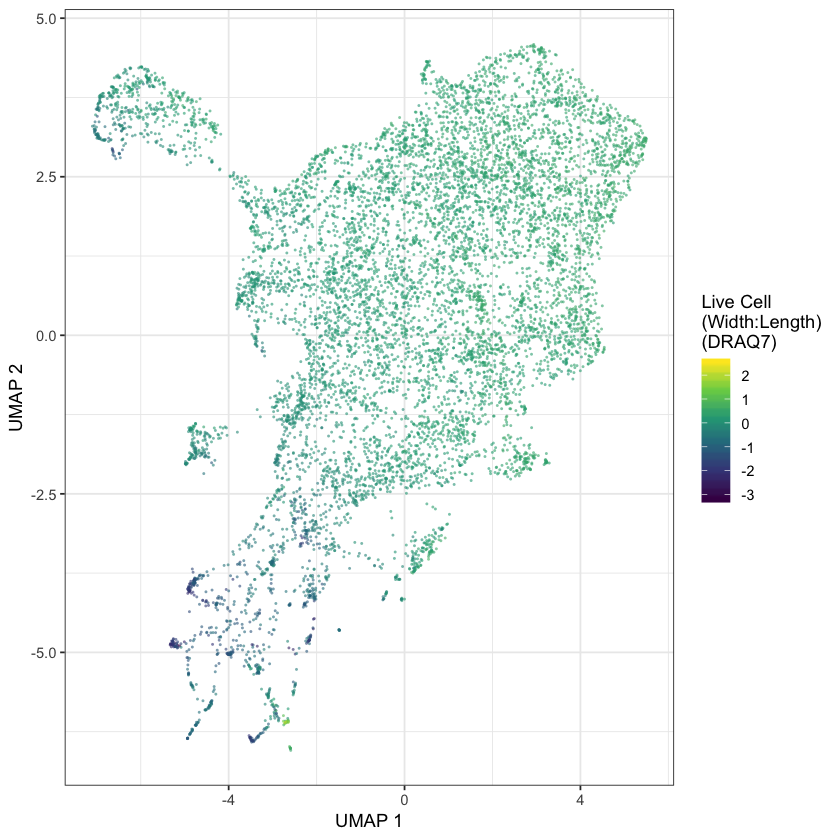

In [12]:
visualize_model(target_variable = "vb_live_cell_width_length",
                legend_title = "Live Cell\n(Width:Length)\n(DRAQ7)")

## Predicting Live Cell Roundness (DRAQ7)

In [13]:
map_df %>% filter(original_name == "Live Cell Roundness")

original_name       updated_name           feature_type measurement
1 Live Cell Roundness vb_live_cell_roundness viability    NA         
  maria_thumbs_up assay description   
1 0               draq  cell roundness

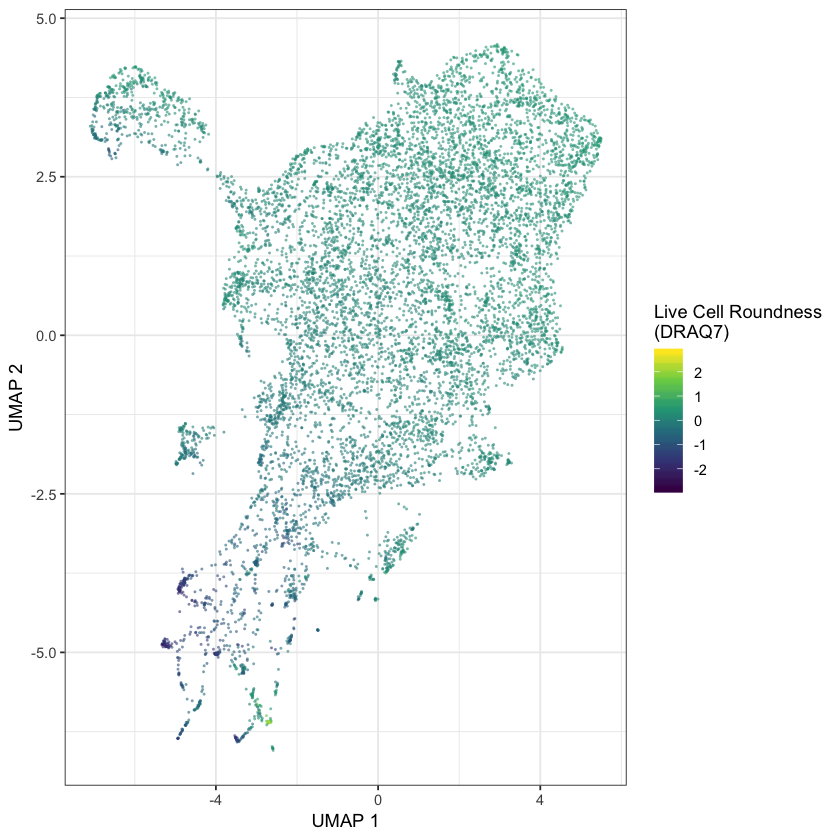

In [14]:
visualize_model(target_variable = "vb_live_cell_roundness",
                legend_title = "Live Cell Roundness\n(DRAQ7)")

## Predicting Number of Objects (Hoechst)

In [15]:
map_df %>% filter(original_name == "ALL - Number of Objects")

original_name           updated_name     feature_type measurement   
1 ALL - Number of Objects cc_all_n_objects cell_cycle   cell_viability
  maria_thumbs_up assay   description          
1 1               hoechst total number of cells

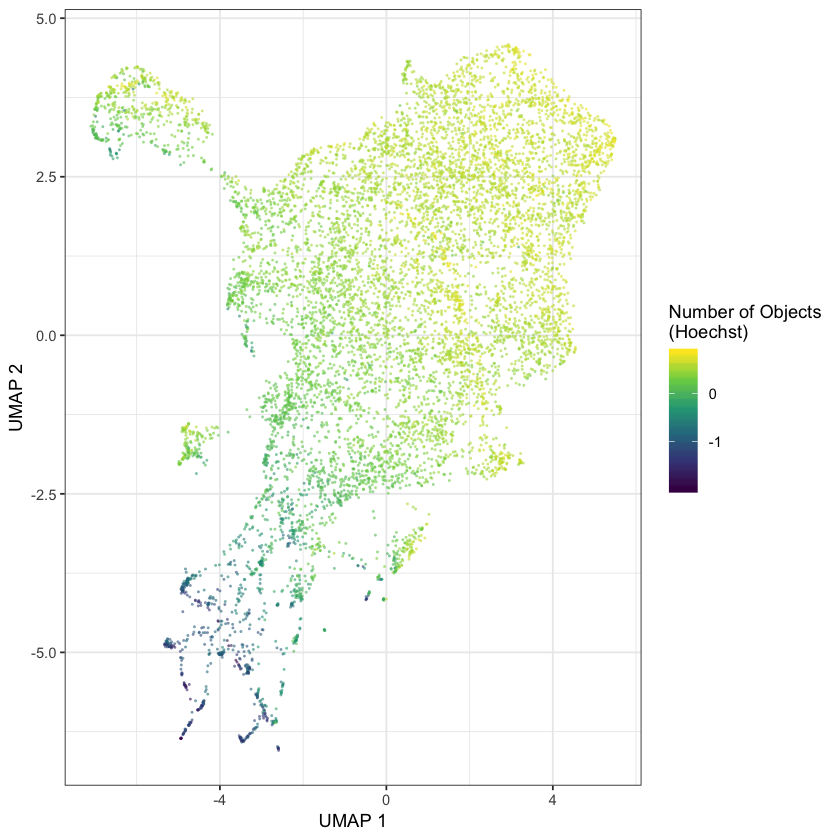

In [16]:
visualize_model(target_variable = "cc_all_n_objects",
                legend_title = "Number of Objects\n(Hoechst)")

## Predicting Live Cell Area (DRAQ7)

In [17]:
map_df %>% filter(original_name == "Live Cell Area")

original_name  updated_name      feature_type measurement maria_thumbs_up
1 Live Cell Area vb_live_cell_area viability    NA          0              
  assay description
1 draq  cell size

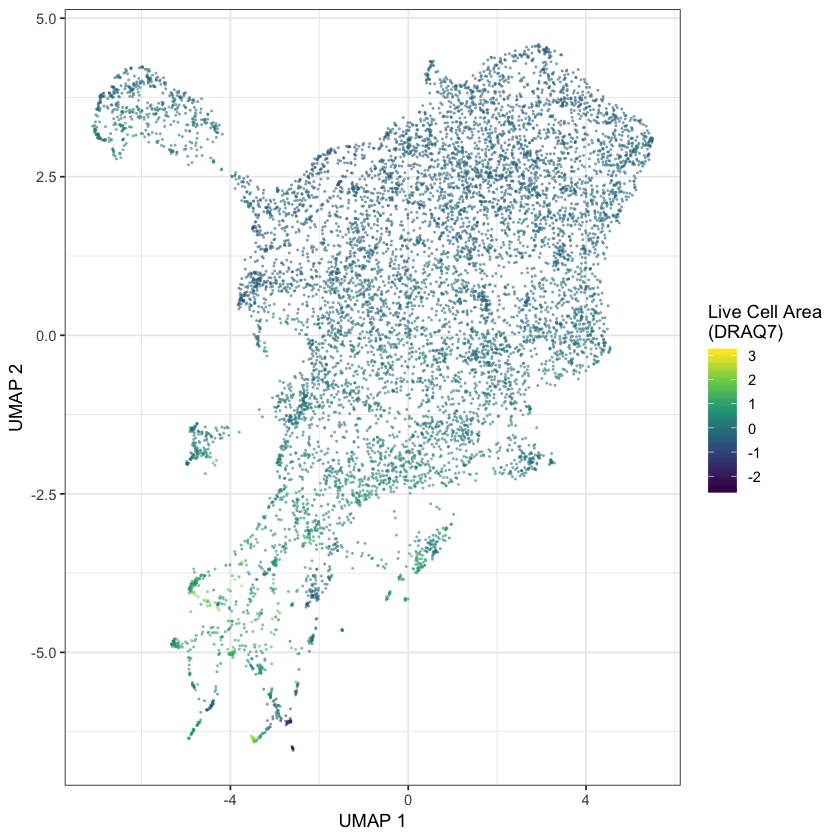

In [18]:
visualize_model(target_variable = "vb_live_cell_area",
                legend_title = "Live Cell Area\n(DRAQ7)")

## Predicting Number of Objects in Cell Cycle Stage (Hoechst)

In [19]:
map_df %>% filter(original_name == "CC - Number of Objects")

original_name          updated_name    feature_type measurement   
1 CC - Number of Objects cc_cc_n_objects cell_cycle   cell_viability
  maria_thumbs_up assay   description                            
1 0               hoechst Number of cells selected for cell cycle

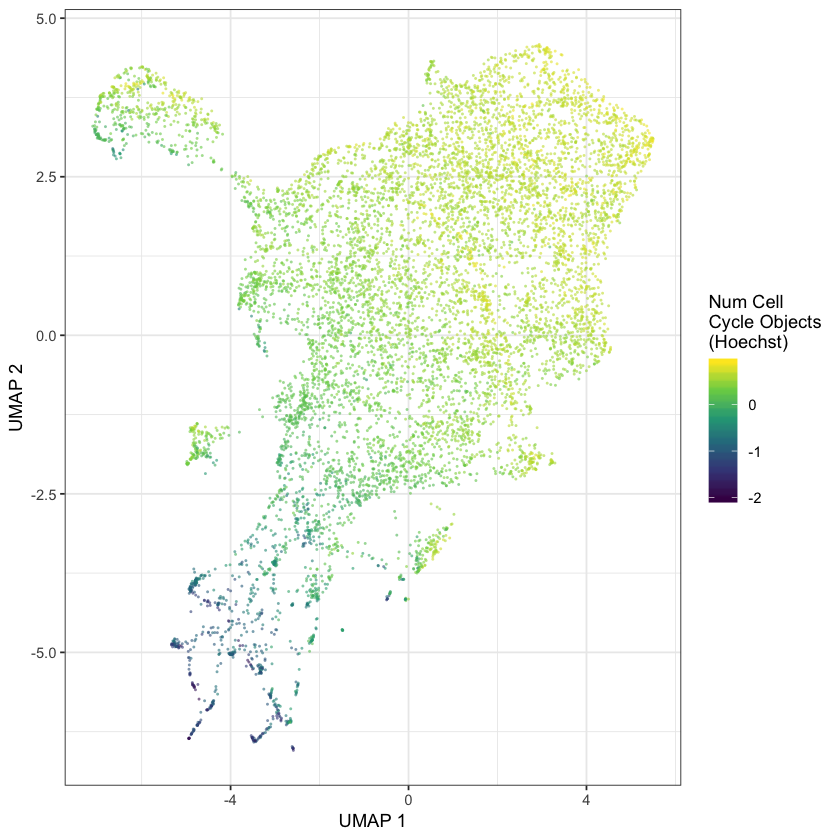

In [20]:
visualize_model(target_variable = "cc_cc_n_objects",
                legend_title = "Num Cell\nCycle Objects\n(Hoechst)")

## Predicting Number of Objects in G1 (Many Dyes)

In [21]:
map_df %>% filter(original_name == "G1 - Number of Objects")

original_name          updated_name    feature_type measurement
1 G1 - Number of Objects cc_g1_n_objects cell_cycle   NA         
  maria_thumbs_up assay           description       
1 0               many_cell_cycle number of G1 cells

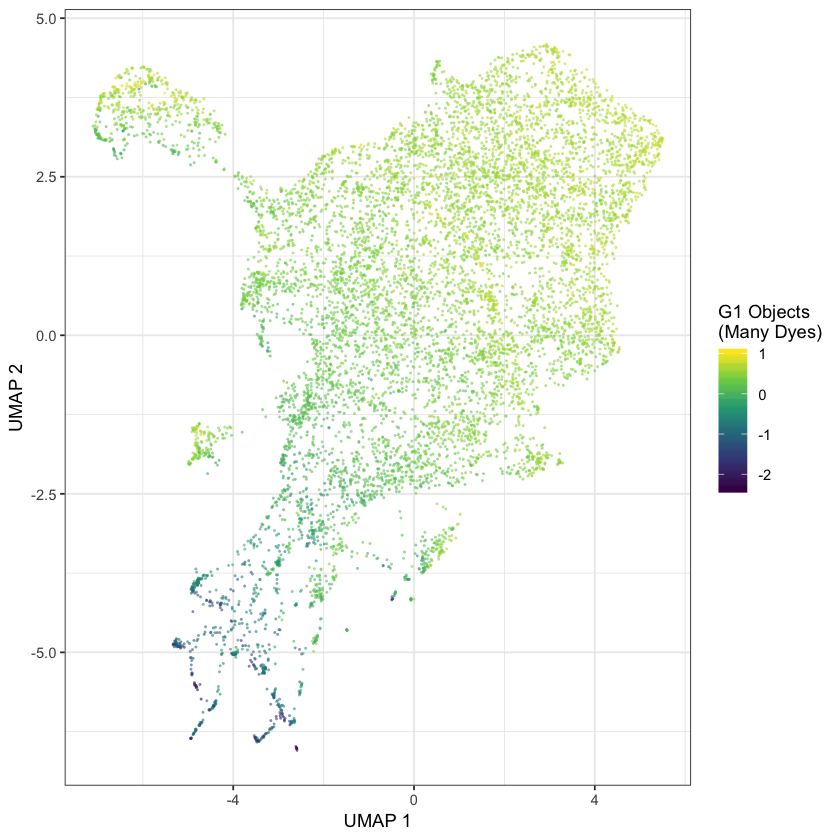

In [22]:
visualize_model(target_variable = "cc_g1_n_objects",
                legend_title = "G1 Objects\n(Many Dyes)")

## Predicting EdU positive intensity

In [23]:
map_df %>% filter(original_name == "edu positive - Intensity Nucleus Alexa 647 Sum - Sum per Well")

original_name                                                
1 edu positive - Intensity Nucleus Alexa 647 Sum - Sum per Well
  updated_name                                   feature_type measurement
1 cc_edu_pos_alexa647_intensity_nucleus_area_sum cell_cycle   s_arrest   
  maria_thumbs_up assay
1 0               edu  
  description                                                                    
1 In S phase cells: how much EdU was incorporated (average total signal per cell)

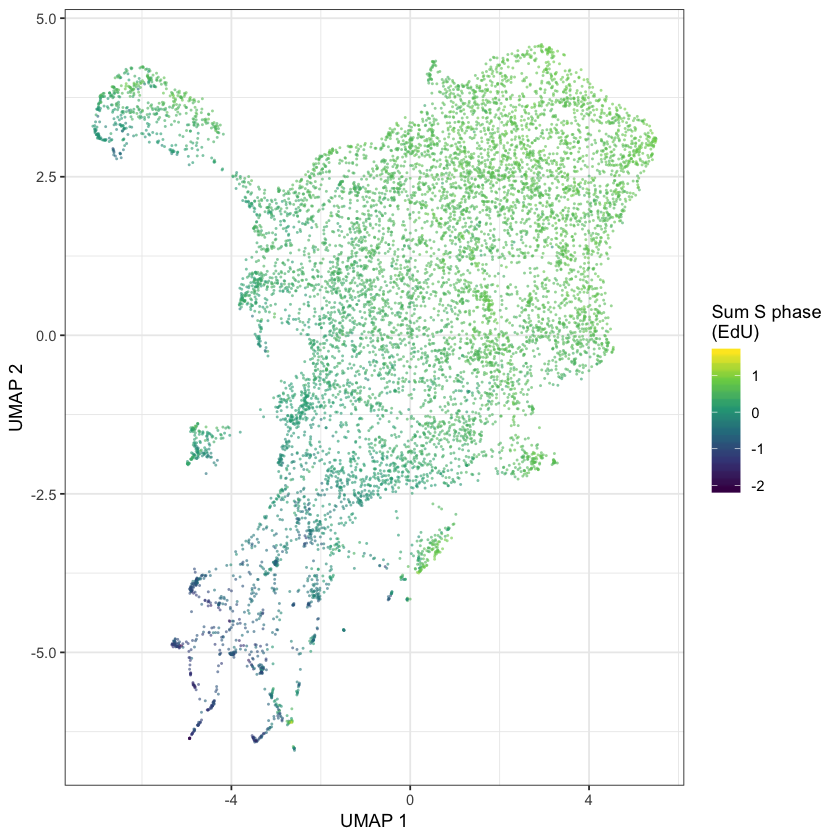

In [24]:
visualize_model(target_variable = "cc_edu_pos_alexa647_intensity_nucleus_area_sum",
                legend_title = "Sum S phase\n(EdU)")

## Predicting Numbe of EdU positive objects

In [25]:
map_df %>% filter(original_name == "edu positive - Number of Objects")

original_name                    updated_name         feature_type
1 edu positive - Number of Objects cc_edu_pos_n_objects cell_cycle  
  measurement maria_thumbs_up assay description            
1 NA          0               edu   number of S-phase cells

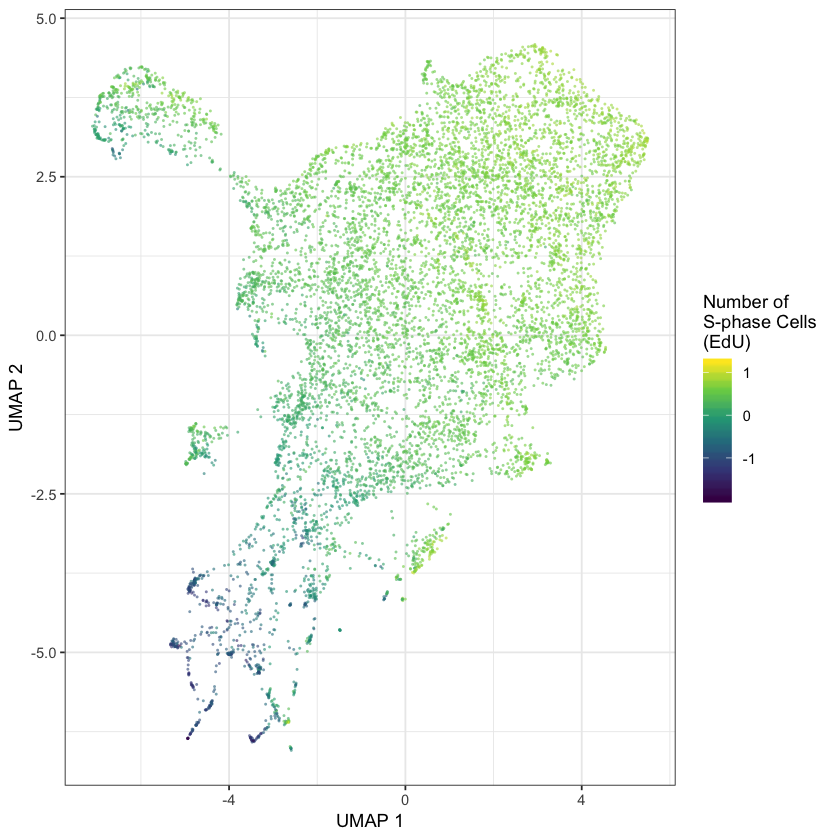

In [26]:
visualize_model(target_variable = "cc_edu_pos_n_objects",
                legend_title = "Number of\nS-phase Cells\n(EdU)")

## Predicting ROS (Caspase)

In [27]:
map_df %>% filter(original_name == "ROS-back Mean")

original_name updated_name     feature_type measurement maria_thumbs_up
1 ROS-back Mean vb_ros_back_mean viability    NA          0              
  assay   description
1 caspase Background

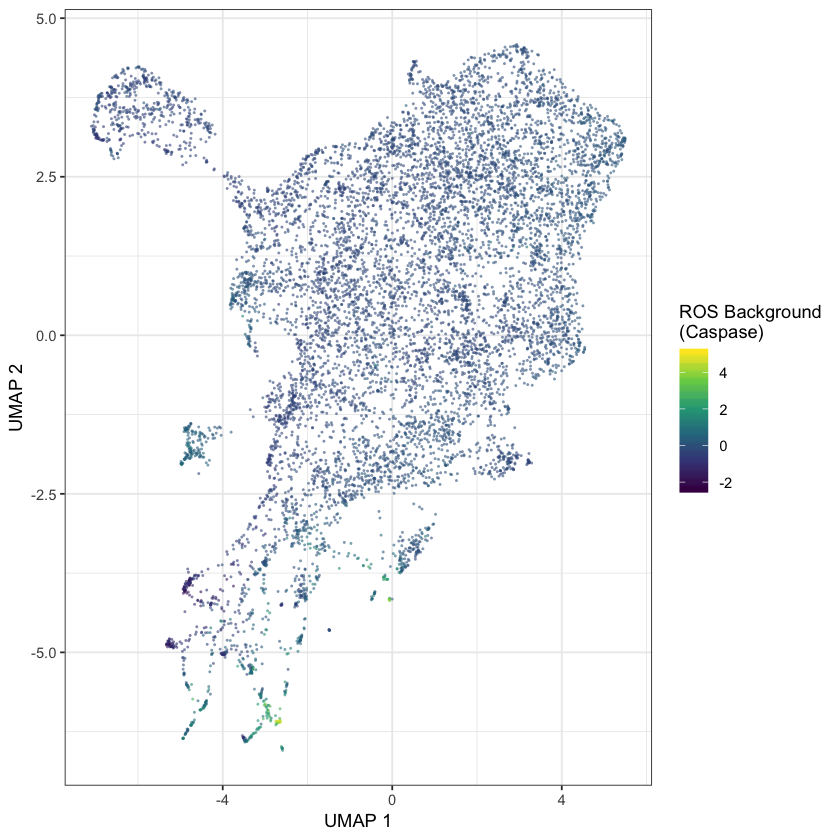

In [28]:
visualize_model(target_variable = "vb_ros_back_mean",
                legend_title = "ROS Background\n(Caspase)")

## Visualize All Cell Health Variables

In [29]:
cell_health_variables <- colnames(
    cp_embedding_df %>%
        dplyr::select(starts_with("cc"), starts_with("vb"))
    )

length(cell_health_variables)

[1] 70

In [30]:
pdf_file <- file.path("figures", "repurposing_hub_umaps_consensus.pdf")
pdf(pdf_file, width = 5, height = 5, onefile = TRUE)

for (cell_health_variable in cell_health_variables) {
    umap_gg <- visualize_model(target_variable = cell_health_variable,
                               legend_title = "Prediction:",
                               title = cell_health_variable,
                               dpi = 200,
                               save_figure = FALSE)
}

dev.off()

pdf 
  2

## Visualize Model Scores on DMSO samples

In [31]:
# Set some plotting defaults
measurement_colors <- c(
    "apoptosis" = "#a6cee3",
    "cell_cycle_arrest" = "#1f78b4",
    "cell_viability" = "#b2df8a",
    "death" = "#33a02c",
    "dna_damage" = "#fb9a99", 
    "g1_arrest" = "#fdbf6f",
    "g2_arrest" = "#ff7f00",
    "g2_m_arrest" = "#005c8c",
    "mitosis" = "green",
    "other" = "black",
    "s_arrest" = "#cab2d6",
    "toxicity" = "#6a3d9a"
)

measurement_labels <- c(
    "apoptosis" = "Apoptosis",
    "cell_cycle_arrest" = "Cell Cycle Arrest",
    "cell_viability" = "Cell Viability",
    "death" = "Death",
    "dna_damage" = "DNA Damage", 
    "g1_arrest" = "G1 Arrest",
    "g2_arrest" = "G2 Arrest",
    "g2_m_arrest" = "G2/M Arrest",
    "mitosis" = "Mitosis",
    "other" = "Other",
    "s_arrest" = "S Arrest",
    "toxicity" = "Toxicity"
)

dye_colors <- c(
    "hoechst" = "#639B94",
    "edu" = "#E45242",
    "gh2ax" = "#E2C552",
    "ph3" = "#7B9C32",
    "hoechst_gh2ax" = "#535f52",
    "hoechst_edu" = "#73414b",
    "edu_gh2ax" = "#e37a48",
    "caspase" = "#F7B1C1",
    "draq" = "#FF6699",
    "draq_caspase" = "#7f4a72",
    "many_cell_cycle" = "#E9DFC3",
    "crispr_efficiency" = "black"
)

dye_labels <- c(
    "hoechst" = "Hoechst",
    "edu" = "EdU",
    "gh2ax" = "gH2AX",
    "ph3" = "pH3",
    "hoechst_gh2ax" = "Hoechst + gH2AX",
    "hoechst_edu" = "Hoechst + EdU",
    "edu_gh2ax" = "EdU + gH2AX",
    "caspase" = "Caspase 3/7",
    "draq" = "DRAQ7",
    "draq_caspase" = "DRAQ7 + Caspase 3/7",
    "many_cell_cycle" = "Cell Cycle (Many Dyes)",
    "crispr_efficiency" = "CRISPR Efficiency"
)

In [32]:
col_types <- readr::cols(
    .default = readr::col_character(),
    shuffle_false = readr::col_double(),
    shuffle_true = readr::col_double()
)

rank_file <- file.path("..", "3.train", "results", "A549_ranked_models.tsv")
model_rank_df <- readr::read_tsv(rank_file, col_types = col_types)

head(model_rank_df, 3)

metric target                    original_name       feature_type measurement
1 r_two  vb_num_live_cells         # Live Cells        viability    death      
2 r_two  vb_live_cell_width_length Live Width:Length   viability    NA         
3 r_two  vb_live_cell_roundness    Live Cell Roundness viability    NA         
  assay description          shuffle_false shuffle_true
1 draq  number of live cells 0.8829303     -0.03018241 
2 draq  width/length         0.8739692      0.30092680 
3 draq  cell roundness       0.8204619     -0.01116531

In [33]:
dmso_embeddings_df <- cp_embedding_df %>%
    dplyr::filter(Metadata_Treatment == "DMSO")

non_dmso_embeddings_df <- cp_embedding_df %>%
    dplyr::filter(Metadata_Treatment != "DMSO")

In [34]:
std_dev_dmso_features <- apply(dmso_embeddings_df %>% dplyr::select(matches("cc_|vb_")), 2, sd)
std_dev_compound_features <- apply(non_dmso_embeddings_df %>% dplyr::select(matches("cc_|vb_")), 2, sd)

In [35]:
std_dev_all_df <- dplyr::bind_cols(as.data.frame(std_dev_dmso_features),
                                   as.data.frame(std_dev_compound_features)) %>%
    dplyr::mutate(features = colnames(dmso_embeddings_df %>% dplyr::select(matches("cc_|vb_")))) %>%
    dplyr::left_join(model_rank_df, by = c("features" = "target")) 

good_performing <- std_dev_all_df %>%
    dplyr::filter(shuffle_false > 0)

bad_performing <- std_dev_all_df %>%
    dplyr::filter(shuffle_false <= 0)

std_dev_good_df <- good_performing %>%
    dplyr::mutate(performance_scaled = (
        good_performing$shuffle_false - min(good_performing$shuffle_false)
    ) / (
        max(good_performing$shuffle_false) - min(good_performing$shuffle_false)
    )
                  )

print(dim(std_dev_good_df))
head(std_dev_good_df, 2)

[1] 37 12


std_dev_dmso_features std_dev_compound_features features               metric
1 0.1063964             0.4840223                 cc_cc_g1_mean          r_two 
2 0.1724422             0.3728292                 vb_live_cell_roundness r_two 
  original_name           feature_type measurement assay          
1 CC - G1 - Mean per Well cell_cycle   g1_arrest   many_cell_cycle
2 Live Cell Roundness     viability    NA          draq           
  description          shuffle_false shuffle_true performance_scaled
1 fraction of G1 cells 0.2108048      0.03124830  0.2346458         
2 cell roundness       0.8204619     -0.01116531  0.9288667

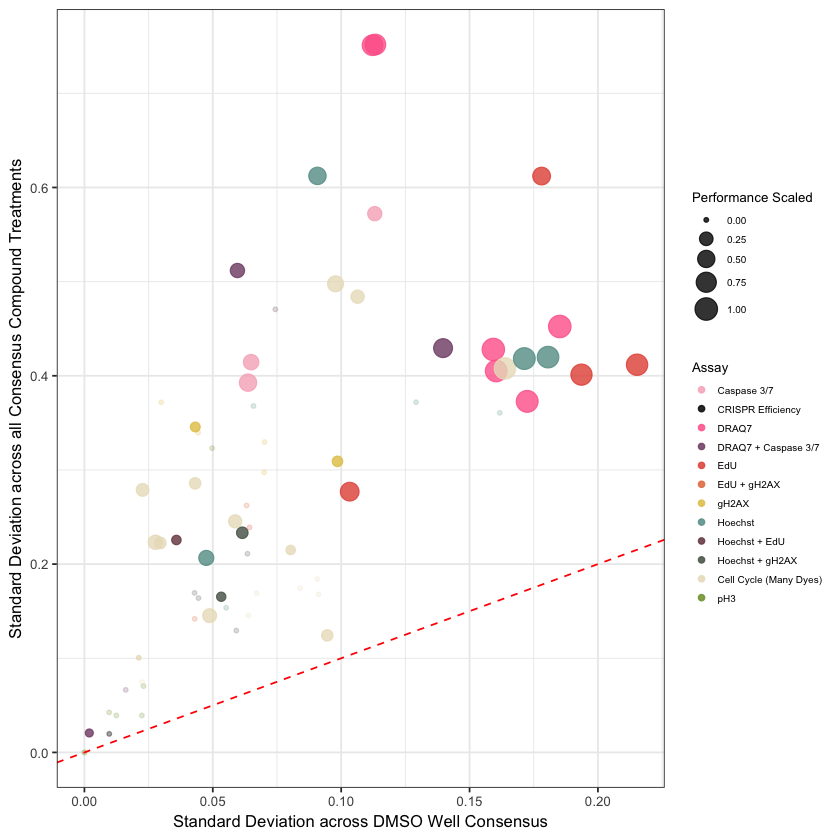

In [36]:
ggplot(std_dev_good_df, aes(x = std_dev_dmso_features, y = std_dev_compound_features)) +
    geom_point(aes(color = assay, size = performance_scaled),
               alpha = 0.8) +
    geom_point(data = bad_performing,
               aes(color = assay),
               size = 1,
               alpha = 0.2) +
    theme_bw() +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
    scale_color_manual(name = "Assay",
                       values = dye_colors,
                       labels = dye_labels) +
    scale_size_continuous(name = "Performance Scaled") + 
    xlab("Standard Deviation across DMSO Well Consensus") +
    ylab("Standard Deviation across all Consensus Compound Treatments") +
    theme(axis.text = element_text(size = 8),
          axis.title = element_text(size = 10),
          strip.text = element_text(size = 6),
          legend.text = element_text(size = 6),
          legend.title = element_text(size = 8),
         legend.key.size = unit(0.4, "cm"))

output_file <- file.path("figures", "dmso_vs_compound_standard_deviation.png")
ggsave(output_file, height = 5, width = 6, dpi = 500)